In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

In [ ]:
# test connetion
!ls '/content/gdrive/My Drive'

In [ ]:
!pip install ultralytics

In [ ]:
# test connetion
!ls '/content/gdrive/My Drive/Netlist generator/'

'Current trained model'  'Model training'  'Program test'   Testing



image 1/1 /content/gdrive/My Drive/Netlist generator/Program test/Netlist generator algorithm test/Test images/GND_test.jpg: 448x640 6 Resistors, 2 Capacitors, 1 Transistor_MOSFET, 1 Voltage_src, 3 GNDs, 1096.1ms
Speed: 3.4ms preprocess, 1096.1ms inference, 1.2ms postprocess per image at shape (1, 3, 448, 640)


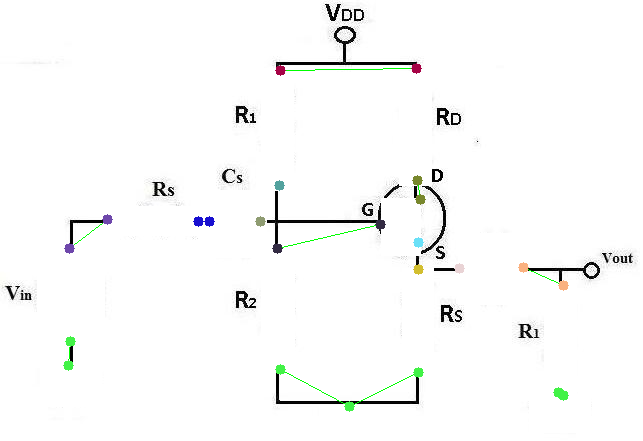

Processing completed for GND_test.jpg. Outputs saved in /content/gdrive/My Drive/Netlist generator/Program test/Netlist generator algorithm test/Method 1/Test outputs/GND_test

image 1/1 /content/gdrive/My Drive/Netlist generator/Program test/Netlist generator algorithm test/Test images/simple_0003.jpg: 608x640 4 Resistors, 1 Transistor_BJT, 2 GNDs, 2429.3ms
Speed: 4.6ms preprocess, 2429.3ms inference, 1.4ms postprocess per image at shape (1, 3, 608, 640)


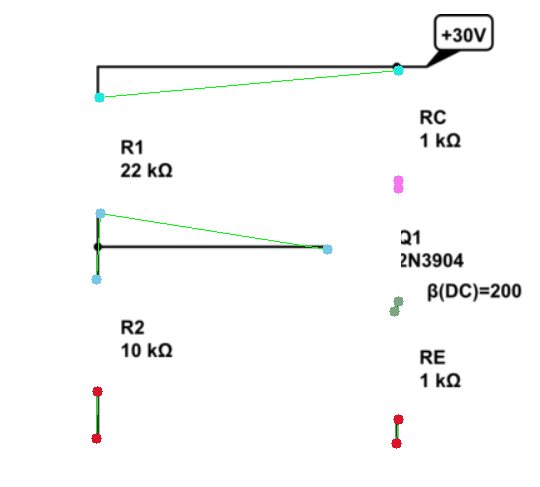

Processing completed for simple_0003.jpg. Outputs saved in /content/gdrive/My Drive/Netlist generator/Program test/Netlist generator algorithm test/Method 1/Test outputs/simple_0003

image 1/1 /content/gdrive/My Drive/Netlist generator/Program test/Netlist generator algorithm test/Test images/simple_0002.jpg: 480x640 3 Resistors, 1 Voltage_src, 1198.9ms
Speed: 2.9ms preprocess, 1198.9ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)


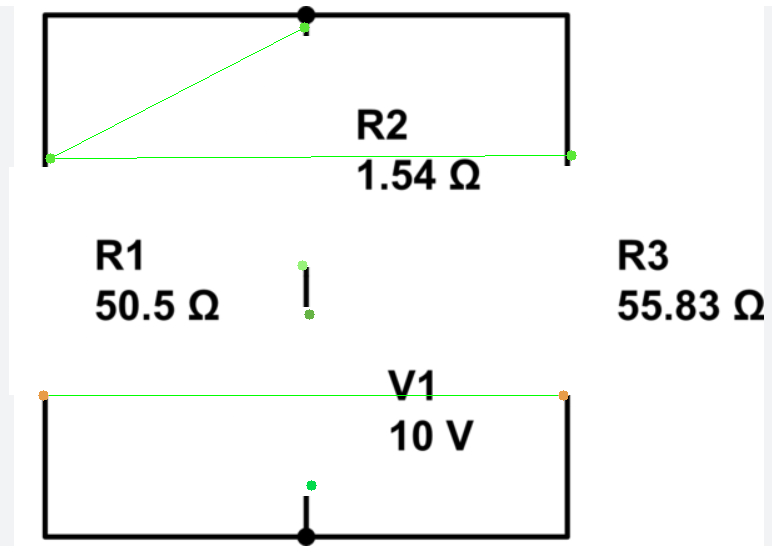

Processing completed for simple_0002.jpg. Outputs saved in /content/gdrive/My Drive/Netlist generator/Program test/Netlist generator algorithm test/Method 1/Test outputs/simple_0002

image 1/1 /content/gdrive/My Drive/Netlist generator/Program test/Netlist generator algorithm test/Test images/simple_0001.jpg: 288x640 3 Resistors, 1 Voltage_src, 735.9ms
Speed: 7.7ms preprocess, 735.9ms inference, 1.1ms postprocess per image at shape (1, 3, 288, 640)


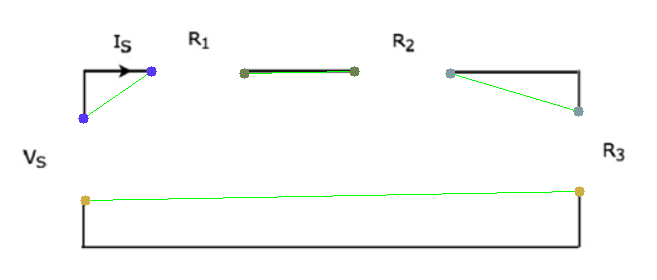

Processing completed for simple_0001.jpg. Outputs saved in /content/gdrive/My Drive/Netlist generator/Program test/Netlist generator algorithm test/Method 1/Test outputs/simple_0001


In [ ]:
import os
from ultralytics import YOLO
import json
import cv2
from google.colab.patches import cv2_imshow
import sys
import numpy as np

#########################################
# GET INFO FROM TRAINED MODEL
#########################################

# Define paths
model_path = '/content/gdrive/My Drive/Netlist generator/Current trained model/pose/train/weights/last.pt'
main_path = '/content/gdrive/My Drive/Netlist generator/Program test/Netlist generator algorithm test/'
test_images_folder = main_path + 'Test images/'
output_base_path = main_path + 'Method 1/Test outputs for debugging/'
test_results_path = main_path + 'Method 1/Test results/'

# Create necessary folders if they don't exist
os.makedirs(test_images_folder, exist_ok=True)
os.makedirs(output_base_path, exist_ok=True)
os.makedirs(test_results_path, exist_ok=True)

# Load YOLO model
model = YOLO(model_path)

# Get all image files in the test folder
image_files = [f for f in os.listdir(test_images_folder) if f.endswith(('.jpg', '.png', '.jpeg'))]

# Maintain a count of each component type
component_counts = {}

# Helper function to generate unique labels
def get_component_label(label):
    if label not in component_counts:
        component_counts[label] = 1
    else:
        component_counts[label] += 1
    return f"{label}_{component_counts[label]}"

# Loop through each image and process it
for image_file in image_files:
    component_counts = {}
    Test_image = os.path.splitext(image_file)[0]  # Extract the image name without extension
    image_path = os.path.join(test_images_folder, image_file)
    files_path = os.path.join(output_base_path, Test_image)
    generated_images_path = os.path.join(files_path, 'Generated images/')
    circuit_info_path = os.path.join(files_path, 'circuit_info.json')
    netlist_file_path = os.path.join(test_results_path, f"{Test_image}.txt")  # Save netlist file

    # Create necessary folders for the current image
    os.makedirs(files_path, exist_ok=True)
    os.makedirs(generated_images_path, exist_ok=True)

    # Run inference
    results = model(image_path)[0]

    # Prepare the list for storing circuit information
    circuit_info = []

    # Process each result
    for result in results:
        # Get keypoints
        keypoints = result.keypoints.xy.cpu().numpy()  # Move tensor to CPU before converting to NumPy
        if len(keypoints) > 0:
            keypoints = keypoints[0]  # Remove extra dimension if necessary

        # Get class index and object name
        class_idx = int(result.boxes.cls.cpu().numpy()[0])  # Convert tensor to numpy, then to int
        object_name = results.names[class_idx]  # Get the class name using the class index

        # Extract bounding box coordinates
        bbox = result.boxes.xyxy.cpu().numpy()[0]  # Move tensor to CPU before converting to NumPy
        x_min, y_min, x_max, y_max = map(int, bbox)  # Convert to integers
        bounding_box = [x_min, y_min, x_max, y_max]

        # Extract keypoints as connection points, ignoring [0, 0]
        connection_points = [
            [int(point[0]), int(point[1])] for point in keypoints if not (point[0] == 0 and point[1] == 0)
        ]

        # Append object information to the list
        circuit_info.append({
            "label": object_name,
            "bounding_box": bounding_box,
            "connection_points": connection_points
        })

    # Save the circuit information as a JSON file
    output_file_path = os.path.join(files_path, 'circuit_info.json')
    try:
        with open(output_file_path, 'w') as json_file:
            json.dump(circuit_info, json_file, indent=4)
    except Exception as e:
        print(f"Failed to save JSON file for {image_file}: {e}")
        continue

    #########################################
    # REMOVE COMPONENTS FROM IMAGE
    #########################################

    # Load the image
    image = cv2.imread(image_path)

    # Create a copy of the image to draw white squares
    image_with_squares = image.copy()

    # Draw white squares over the components using the bounding boxes
    for component in circuit_info:
        x1, y1, x2, y2 = component["bounding_box"]
        cv2.rectangle(image_with_squares, (x1, y1), (x2, y2), (255, 255, 255), thickness=-1)  # Fill with white

    # Save the image with white squares over the components
    image_with_squares_path = os.path.join(generated_images_path, 'circuit_diagram_with_removed_components.png')
    cv2.imwrite(image_with_squares_path, image_with_squares)

    #########################################
    # DRAW CONNECTION POINTS
    #########################################

    # Load the existing image
    image = cv2.imread(image_with_squares_path)

    # Create a copy of the image to draw circles for connection points
    image_with_circles = image.copy()

    # Draw connection points and prepare the JSON output
    for component in circuit_info:
        for point in component["connection_points"]:
            cv2.circle(image_with_circles, tuple(point), 5, (0, 255, 0), -1)  # Green for connection points

    # Save the image with the circles
    output_path = os.path.join(generated_images_path, 'circuit_diagram_with_connection_points.png')
    cv2.imwrite(output_path, image_with_circles)

    #########################################
    # FIND NODES
    #########################################

    # Load the image with the grid and mask
    image_with_mask_path = output_path
    image = cv2.imread(image_with_mask_path)

    # Parameters for white space detection and connection
    WHITE_THRESHOLD = 240  # Threshold for white space
    connection_color = (0, 255, 0)  # Green for connections
    connection_thickness = 1

    # Define the directions to move for BFS (8 directions: horizontal, vertical, and diagonals)
    directions = [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (-1, 1), (1, -1), (1, 1)]

    # Define function to check if a pixel is part of the white space
    def is_white(pixel):
        return np.mean(pixel) >= WHITE_THRESHOLD

    # Union-Find (Disjoint Set) data structure to group connected dots
    class UnionFind:
        def __init__(self, n):
            self.parent = list(range(n))
            self.rank = [1] * n

        def find(self, x):
            if self.parent[x] != x:
                self.parent[x] = self.find(self.parent[x])  # Path compression
            return self.parent[x]

        def union(self, x, y):
            rootX = self.find(x)
            rootY = self.find(y)
            if rootX != rootY:
                if self.rank[rootX] > self.rank[rootY]:
                    self.parent[rootY] = rootX
                elif self.rank[rootX] < self.rank[rootY]:
                    self.parent[rootX] = rootY
                else:
                    self.parent[rootY] = rootX
                    self.rank[rootX] += 1

    # Load the connection points for components from 'circuit_info.json'
    with open(circuit_info_path, 'r') as json_file:
        circuit_info = json.load(json_file)

    # Extract dots from the circuit info
    dots = []
    for component in circuit_info:
        dots.extend([tuple(point) for point in component["connection_points"]])

    # Get image dimensions
    height, width, _ = image.shape

    # Initialize the Union-Find structure with the number of dots
    uf = UnionFind(len(dots))

    # Initialize connection tracking for each dot
    connections = {dot: 0 for dot in dots}

    # Function to connect dots
    def bfs_connect(start, target, image, height, width):
        queue = [start]
        visited = set()
        visited.add(start)

        while queue:
            x, y = queue.pop(0)
            if (x, y) == target:
                return True
            for dx, dy in directions:
                nx, ny = x + dx, y + dy
                if 0 <= nx < width and 0 <= ny < height and (nx, ny) not in visited and not is_white(image[ny, nx]):
                    visited.add((nx, ny))
                    queue.append((nx, ny))
        return False

    # Connect dots
    for i in range(len(dots)):
        for j in range(i + 1, len(dots)):
            dot1 = dots[i]
            dot2 = dots[j]
            if uf.find(i) == uf.find(j):
                continue
            if bfs_connect(dot1, dot2, image, height, width):
                if connections[dot1] <= connections[dot2]:
                    uf.union(i, j)
                    connections[dot1] += 1
                    cv2.line(image, dot1, dot2, connection_color, connection_thickness)
                else:
                    uf.union(j, i)
                    connections[dot2] += 1
                    cv2.line(image, dot2, dot1, connection_color, connection_thickness)

    # Initialize a mapping from Union-Find roots to new continuous node numbers
    node_mapping = {}
    current_node_number = 0

    # Ensure node 0 is ground
    ground_nodes = set()
    for component in circuit_info:
        if component['label'].upper() == 'GND':
            for point in component['connection_points']:
                ground_node_index = dots.index(tuple(point))
                root = uf.find(ground_node_index)
                if root not in node_mapping:
                    node_mapping[root] = 0  # Assign ground to node 0
                    ground_nodes.add(0)
                    break

    # Assign numbers to other nodes
    for i, dot in enumerate(dots):
        root = uf.find(i)
        if root not in node_mapping:
            current_node_number += 1
            node_mapping[root] = current_node_number

    # Helper function to find which node a point belongs to
    def find_node_for_point(point):
        for i, dot in enumerate(dots):
            if dot == point:
                root = uf.find(i)
                return node_mapping[root]
        return None

    # Process each component and determine its connected nodes
    component_connections = []
    for component in circuit_info:
        label = component['label']
        points = component['connection_points']
        if len(points) == 2:
            node1 = find_node_for_point(tuple(points[0]))
            node2 = find_node_for_point(tuple(points[1]))
            if node1 is not None and node2 is not None:
                if node1 in ground_nodes:
                    node1 = 0
                if node2 in ground_nodes:
                    node2 = 0
                component_connections.append(f"{get_component_label(label)} {node1} {node2}")
        elif len(points) == 3:
            node1 = find_node_for_point(tuple(points[0]))
            node2 = find_node_for_point(tuple(points[1]))
            node3 = find_node_for_point(tuple(points[2]))
            if node1 is not None and node2 is not None and node3 is not None:
                if node1 in ground_nodes:
                    node1 = 0
                if node2 in ground_nodes:
                    node2 = 0
                if node3 in ground_nodes:
                    node3 = 0
                component_connections.append(f"{get_component_label(label)} {node1} {node2} {node3}")

    # Save the connections in the required format to a file
    try:
        with open(netlist_file_path, 'w') as netlist_file:
            for connection in component_connections:
                netlist_file.write(connection + '\n')
    except Exception as e:
        print(f"Failed to save netlist for {image_file}: {e}")
        continue

    # Assign a unique color to each node
    node_colors = {}
    def assign_node_color(node_number):
        if node_number not in node_colors:
            node_colors[node_number] = tuple(np.random.randint(0, 256, size=3).tolist())
        return node_colors[node_number]

    # Draw nodes with distinct colors
    for i, dot in enumerate(dots):
        node_number = node_mapping[uf.find(i)]
        color = assign_node_color(node_number)
        cv2.circle(image, dot, 5, color, -1)  # Draw the node with its color

    # Save the final image with the connections drawn
    output_image_with_connections_path = os.path.join(generated_images_path, 'circuit_diagram_with_final_connections.png')
    cv2.imwrite(output_image_with_connections_path, image)

    cv2_imshow(image)

    print(f"Processing completed for {image_file}. Outputs saved in {files_path}")
